# Enunciado do Exercício: Modelo de Linguagem (Bengio 2003) - MLP + Embeddings

Neste exercício, o objetivo é implementar e treinar uma rede neural similar a do (Bengio et al, 2003) para prever a próxima palavra de um texto, data as palavras anteriores como entrada. Esta tarefa é chamada de "Modelagem da Linguagem".

O modelo deve ser simplificado, utilizando-se de: Embedding e duas camadas: uma não linear e outra de saída com tamanho do vocabulário. Avalie a perplexidade do modelo, esperada menor que 200, e implemente uma função que permite a geração de texto baseada num contexto de, por exemplo, 5 palavras. Dica: remova exemplos do dataset exemplos com índice 0 (palavras desconhecidas pelo vocabulário).

O uso do ChatGPT ou similares é permitido e incentivado. Procure usar o modelo para aprender sobre os assuntos. A entrega deve ser no formato de Notebook Colab, com formatação e dataset livre. Alguns alunos serão sorteados para discussão da solução na próxima aula.

# Imports

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from collections import Counter
import random
import os
import matplotlib.pyplot as plt
from datasets import load_dataset
import time
from pathlib import Path
import datasets as hfds
import json

/Users/mabosco/Desktop/mestrado/IA368HH/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dados

## Importa dataset pré-processado

Importa artefatos gerados pelo notebook [Preparação_de_dados.ipynb](Preparação_dos_dados.ipynb), compartilhado pelo aluno Augusto Zolet.  
  
Ao fim desta subsessão teremos o dataset tratado, tokenizado e dividido entre treino (80%) e teste (20%).  
  
**Next step:** definir pares context (X - 5 tokens) e target (Y - 6º token a ser predito).

In [ ]:
# Pasta onde você salvou os artefatos na etapa anterior
GDRIVE_DIR = "../machado_artifacts"  # ajuste se usou outro caminho
p = Path(GDRIVE_DIR)
assert p.exists(), f"Pasta não encontrada: {p}. Verifique o caminho."

In [ ]:
def load_jsonl_as_hfds(path: Path) -> hfds.Dataset:
    """Carrega um JSONL em um HuggingFace Dataset."""
    with open(path, "r", encoding="utf-8") as f:
        records = [json.loads(line) for line in f]
    return hfds.Dataset.from_list(records)

def load_vocab(path: Path):
    with open(path, "r", encoding="utf-8") as f:
        itos = [line.rstrip("\n") for line in f]
    stoi = {tok: i for i, tok in enumerate(itos)}
    return itos, stoi

In [ ]:
# Arquivos esperados
train_path = p / "train.jsonl"
val_path   = p / "val.jsonl"
vocab_path = p / "vocab.txt"
tokcfg_path= p / "tokenizer_config.json"
manifest_path = p / "manifest.json"

for path in [train_path, val_path, vocab_path, tokcfg_path, manifest_path]:
    assert path.exists(), f"Arquivo ausente: {path}"

In [ ]:
# Carrega splits
train = load_jsonl_as_hfds(train_path)
val   = load_jsonl_as_hfds(val_path)

# Carrega vocabulário e configs do tokenizador
itos, stoi = load_vocab(vocab_path)  # itos[0] deve ser "<unk>"
with open(tokcfg_path, "r", encoding="utf-8") as f:
    tok_cfg = json.load(f)

# (Opcional) Lê manifest para checagens/metadata
with open(manifest_path, "r", encoding="utf-8") as f:
    manifest = json.load(f)

In [ ]:
# Resumo rápido
print(f"[loaded] train={len(train)} segmentos | val={len(val)} segmentos | vocab_size={len(itos)}")
print(f"[cfg] ctx={manifest.get('context_size', 'NA')} | unk='{itos[0] if itos else 'NA'}' | tokenizer flags={tok_cfg.get('strip_urls')}, {tok_cfg.get('map_numbers')}")

# Prévia de um exemplo
ex = train[0]
print("[ex/train] text:", (ex["text"][:120] + ("..." if len(ex["text"]) > 120 else "")))
print("[ex/train] ids[:30]:", ex["ids"][:30])

[loaded] train=140965 segmentos | val=35048 segmentos | vocab_size=2001
[cfg] ctx=5 | unk='<unk>' | tokenizer flags=True, True
[ex/train] text: e saiu, com efeito, com direção ao
[ex/train] ids[:30]: [6, 293, 1, 15, 368, 1, 15, 1335, 23]


In [ ]:
train[0]

{'text': 'e saiu, com efeito, com direção ao',
 'ids': [6, 293, 1, 15, 368, 1, 15, 1335, 23]}

In [ ]:
val[0]

{'text': 'que te parece, adelaide? a moça não respondeu.',
 'ids': [4, 215, 197, 1, 578, 29, 3, 107, 8, 225, 2]}

In [ ]:
type(train)

datasets.arrow_dataset.Dataset

## Importa vocabulário já definido
  
Vocabulário de tamanho = 2000 (top 2000 tokens de maior ocorrência em [projetomachado](../02.%20Aula%201_2%20-%20Bengio/projetomachado/textonormalizado1000.txt)).

In [ ]:
with open(f"{GDRIVE_DIR}/vocab.txt", "r", encoding="utf-8") as f:
    vocab = {word.strip(): idx for idx, word in enumerate(f)}
print(f"Vocab size: {len(vocab)}")

Vocab size: 2001


In [ ]:
vocab

{'<unk>': 0,
 ',': 1,
 '.': 2,
 'a': 3,
 'que': 4,
 'de': 5,
 'e': 6,
 'o': 7,
 'não': 8,
 ';': 9,
 'um': 10,
 'do': 11,
 'da': 12,
 'os': 13,
 'é': 14,
 'com': 15,
 'uma': 16,
 'se': 17,
 'em': 18,
 'para': 19,
 'mas': 20,
 'as': 21,
 'era': 22,
 'ao': 23,
 'por': 24,
 'no': 25,
 'à': 26,
 'mais': 27,
 'na': 28,
 '?': 29,
 'ele': 30,
 'como': 31,
 'lhe': 32,
 'eu': 33,
 'me': 34,
 'ou': 35,
 'foi': 36,
 '!': 37,
 'dos': 38,
 '...': 39,
 'nem': 40,
 'ela': 41,
 ':': 42,
 'das': 43,
 'quando': 44,
 'sem': 45,
 'casa': 46,
 'disse': 47,
 'depois': 48,
 'já': 49,
 'há': 50,
 'tinha': 51,
 'tudo': 52,
 'ser': 53,
 'num': 54,
 'ainda': 55,
 'só': 56,
 'tempo': 57,
 'olhos': 58,
 'meu': 59,
 'nada': 60,
 'muito': 61,
 'minha': 62,
 'outra': 63,
 'd': 64,
 'outro': 65,
 'também': 66,
 'mesmo': 67,
 'dia': 68,
 'tão': 69,
 'estava': 70,
 'seu': 71,
 'porque': 72,
 'vez': 73,
 'até': 74,
 'sua': 75,
 'esta': 76,
 'assim': 77,
 'este': 78,
 'nos': 79,
 'pouco': 80,
 'agora': 81,
 'às': 82,
 'hom

## Classe do dataset

A Classe Dataset é um dos aspectos mais trabalhosos do desenvolvimento de modelos com Deep Learning. Crie uma classe Dataset do PyTorch para este problema. Lembre-se de documentar e testar utilizando-se de asserts. Explique sua lógica de forma concisa com comentários.  

In [ ]:
# Função para criar pares (X, Y) a partir de uma lista de ids
def create_xy_pairs(dataset, context_size=5):
    X, Y = [], []
    for ex in dataset:
        ids = ex["ids"]
        # Gera pares apenas se houver tokens suficientes
        for i in range(context_size, len(ids)):
            context = ids[i-context_size:i]
            target = ids[i]
            # Remove exemplos com <unk> (ids == 0) no contexto ou target
            if 0 not in context and target != 0:
                X.append(context)
                Y.append(target)
    return X, Y

context_size = 5 # 5 palavras de entrada. O target é a próxima palavra
X_train, Y_train = create_xy_pairs(train, context_size)
X_val, Y_val = create_xy_pairs(val, context_size)

print(f"Pares treino: {len(X_train)}")
print(f"Pares validação: {len(X_val)}")

Pares treino: 581125
Pares validação: 143086


In [ ]:
# os pares são apenas dos ids
X_train[0], Y_train[0]

([6, 293, 1, 15, 368], 1)

In [ ]:
print(f"X_train: min={min(map(min, X_train))}, max={max(map(max, X_train))}")
print(f"X_val: min={min(map(min, X_val))}, max={max(map(max, X_val))}")

X_train: min=1, max=2000
X_val: min=1, max=2000


In [ ]:
from torch.utils.data import Dataset, DataLoader

class MachadoDataset(Dataset):
    """Dataset para modelagem de linguagem com contexto.

    Attributes:
        X = contexts: lista de contextos (N, context_size)
        Y = targets: lista de alvos (N,)
        context_size (int): Tamanho do contexto (janela de tokens)
    """

    def __init__(self, X, Y, context_size=5):
        """Inicializa o dataset.

        Args:
            contexts: Lista ou tensor de contextos (cada contexto tem context_size tokens)
            targets: Lista ou tensor de tokens alvo
            context_size: Tamanho do contexto (default: 5)
        """
        # Validações
        assert len(X) == len(Y), "Número de contextos e alvos deve ser igual"
        if isinstance(X, list):
            assert all(len(ctx) == context_size for ctx in X), \
                f"Todos os contextos devem ter tamanho {context_size}"

        # Converte para tensores
        self.X = torch.tensor([[x for x in ctx] for ctx in X], dtype=torch.long)
        self.Y = torch.tensor([y for y in Y], dtype=torch.long)

        self.context_size = context_size

    def __len__(self):
        """Retorna o número total de exemplos."""
        return len(self.X)

    def __getitem__(self, idx):
        """Retorna um par (contexto, alvo).
        Args:
            idx: Índice do exemplo
        Returns:
            tuple: (context_tensor, target_tensor)
        """
        return self.X[idx], self.Y[idx]

In [ ]:
train_data = MachadoDataset(X_train,Y_train,context_size=context_size)
val_data = MachadoDataset(X_val,Y_val,context_size=context_size)

In [ ]:
print(f"Tamanho do train_data: {len(train_data)}")
print(f"Tamanho do val_data: {len(val_data)}")

Tamanho do train_data: 581125
Tamanho do val_data: 143086


In [ ]:
# Checar o maior índice de token em train_data e val_data

max_train_idx = max([max(x[0]) for x in train_data])
max_val_idx = max([max(x[0]) for x in val_data])

print(f"Maior índice em train_data: {max_train_idx}")
print(f"Maior índice em val_data: {max_val_idx}")

Maior índice em train_data: 2000
Maior índice em val_data: 2000


### Inicialização de DataLoaders
Os DataLoaders do PyTorch cuidam da criação do batch de forma eficiente e com possibildade de paralelismo. Sempre visualize exemplos do DataLoader para verificar que o batch está sendo criado da forma esperada. Grande parte dos erros ocorrem na definição do Dataset e do Dataloader.

In [ ]:
batch_size = 256       # tamanho do batch
embed_dim_glob = 128   # dimensao do vetor de embedding (m)
hidden_dim_glob = 512  # dimensao da camada oculta (h)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
sample = next(iter(train_loader))

In [ ]:
vocab_size_max = 2000
X_testinho, Y_testinho = sample
print(f"Batch shapes: X={X_testinho.shape}, Y={Y_testinho.shape}")
print(f"X range: [{X_testinho.min()}, {X_testinho.max()}]")
print(f"Y range: [{Y_testinho.min()}, {Y_testinho.max()}]")
print(f"Vocabulary size: {vocab_size_max}")

Batch shapes: X=torch.Size([256, 5]), Y=torch.Size([256])
X range: [1, 1994]
Y range: [1, 1985]
Vocabulary size: 2000


# Model
Crie uma classe de Modelo herdando de torch.nn.Module. Um nn.Module deve definir o que acontece no "forward", ou seja, o que é feito com o dado (geralmente o batch) fornecido para a rede.

Procure ler sobre a documentação do nn.Module e entender porque é necessário que a classe do modelo precisa herdar de nn.Module.

In [ ]:
class LanguageModel(nn.Module):
    def __init__(
                self,
                vocab_size=2000 + 1, # top 2000 + 1 unk
                embedding_dim=128,
                hidden_dim=256,
                context_size=5
            ):
        """
        Args:
            vocab_size: Tamanho do vocabulário
            embedding_dim: Dimensionalidade dos embeddings
            hidden_dim: Dimensionalidade da camada oculta
            context_size: Tamanho do contexto (número de palavras de entrada)
        """
        super(LanguageModel, self).__init__()

        # Camada de embedding
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)

        # Camada oculta (não-linear)
        self.hidden = nn.Sequential(
            nn.Linear(context_size * embedding_dim, hidden_dim),
            nn.Tanh()
        )

        # Camada de saída
        self.output = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        # x tem shape (batch_size, context_size)
        embeds = self.embeddings(x)  # (batch_size, context_size, embedding_dim)

        # Achatar os embeddings do contexto
        embeds = embeds.view(embeds.shape[0], -1)  # (batch_size, context_size * embedding_dim)

        # Passar pela camada oculta
        hidden = self.hidden(embeds)  # (batch_size, hidden_dim)

        # Camada de saída
        out = self.output(hidden)  # (batch_size, vocab_size)

        return out

### Teste do modelo
É essencial testar o forward do modelo antes de tentar treinar, muitos erros podem ser pegos neste teste rápido. Use uma amostra do DataLoader para testar se as saídas são o esperado.

In [ ]:
model = LanguageModel()
print(model)

LanguageModel(
  (embeddings): Embedding(2001, 128)
  (hidden): Sequential(
    (0): Linear(in_features=640, out_features=256, bias=True)
    (1): Tanh()
  )
  (output): Linear(in_features=256, out_features=2001, bias=True)
)


In [ ]:
input = sample[0]
target = sample[1]

In [ ]:
output = model(input)

In [ ]:
output.argmax(dim=1)

tensor([ 809, 1787, 1395,  732, 1713, 1994,  709, 1256, 1282, 1101, 1495,  230,
        1701,  294,  327,  433,  911,  166,  471,  435, 1458,   83,  384, 1738,
        1295, 1236,  642,  108, 1443, 1630, 1569, 1689, 1008, 1145, 1074,  877,
         502, 1752, 1340,  960, 1924,  454, 1682, 1242,  779,  516, 1820, 1297,
        1951, 1888, 1526, 1408, 1071, 1376, 1251, 1227, 1385,  433, 1146,  403,
         659, 1859,  503,  668,  852, 1733,  605,  634, 1251, 1863, 1631,  777,
          80, 1228, 1817,  106,   42, 1961, 1679, 1294,  467, 1636, 1527, 1409,
        1022, 1857,  374, 1759,  338, 1403,  209,  986,  538, 1127, 1095, 1640,
        1795, 1649,  191,  108,  100,  884, 1988,  692,    4, 1359,  625,  782,
        1032,  517,   60, 1385,  502, 1144,  548, 1397, 1206, 1819, 1322,  399,
         175,  905,  744,  401,  846, 1289,  488, 1743, 1939,  144,  252, 1445,
         772,  757,  296,   31, 1780,  573, 1838,  494,  448, 1105, 1040, 1560,
          19, 1227, 1565,  108,  399, 18

In [ ]:
target

tensor([   7, 1595,   48,   17,  847,    8,    4, 1344,   32,  517,  382,   64,
           3,    2,    1,    9,   42,   25,    4,  194,  657,    6,  794,   59,
          17,    4,    9,   17,    4,    1,  325,    6,   34,   10,    8,  348,
         327,   88,    1,  494,   32,  106,    1,    1,  241,   33,    5,   10,
        1593,    1, 1684,   21,   13, 1985,    1,    7,    7,    7,   18,  515,
           9,    2, 1733,    3,   59,   16,    3,  452,   37,  101,  570,   11,
         118,   20,   74,    1,   39,    3,  179,    7,   24,    1,   58,    5,
           9,    2,  747,  728,  633,    6,  753,    4,  112,   77,  922,   32,
         764,    9,    8,  549,   22,  550,  136,    2,    5,  288,   34,    8,
        1423,  729,    1,  927,    1,    1,  475,   51,   44,   56, 1012,   66,
        1346,    8,   17,    1, 1608,   22,   14,    8,  240,   15,   30,    2,
          14,    2,  484,    9,   65,    7,    6,  396,   26,    5,    1,  752,
           7,  874,    2,   14,  587,  1

## Training
Finalmente, implemente o loop de treino, onde os dados são fornecidos ao modelo, e os otimizadores otimizam os pesos do modelo em uma tentativa de minimizar a função de perda.

Ele envolve o uso de instâncias de otimizadores e funções de perda. Procure organizar o loop de treino em múltiplas funções em vez de um código monolítico, para facilitar a re-utilização de código no futuro.

Procure informar o resultado da loss tanto em treino quanto em validação. Opcional: plote um gráfico da loss em cada época de treino e validação.

In [ ]:
# Verifica se há uma GPU disponível e define o dispositivo para GPU se possível, caso contrário, usa a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
# define finçao de treinamento e validação
def train_batch(model, X, Y, optimizer, criterion, device):
    model.train()

    #X, Y = data
    X, Y = X.to(device), Y.to(device)

    # forward pass
    output = model(X)
    loss = criterion(output, Y)

    # backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

@torch.no_grad()
def validate_batch(model, X, Y, criterion, device):
    model.eval()

    #X, Y = data
    X, Y = X.to(device), Y.to(device)

    output = model(X)
    loss = criterion(output, Y)

    return loss.item()

In [ ]:
model.output.out_features

2001

In [ ]:
# define função de treinamento do modelo
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    # Validação inicial
    vocab_size = model.output.out_features

    def validate_indices(loader, split_name):
        for batch_idx, (X, Y) in enumerate(loader):
            if X.max() >= vocab_size:
                raise ValueError(f"Batch {batch_idx} em {split_name} tem índice {X.max()} >= vocab_size {vocab_size}")
            if Y.max() >= vocab_size:
                raise ValueError(f"Batch {batch_idx} em {split_name} tem target {Y.max()} >= vocab_size {vocab_size}")

    print("Validando índices...")
    validate_indices(train_loader, "train")
    validate_indices(val_loader, "val")
    print("Validação ok!")

    # treinamento
    model.to(device)

    losses_train = []  # losses for plotting
    losses_val = []  # losses for plotting

    perplexities_train = []  # perplexities for plotting
    perplexities_val = []  # perplexities for plotting

    for epoch in range(epochs):
        N = len(train_loader)  # number of batches
        train_loss = 0.0
        val_loss = 0.0
        start_time = time.time()
        for batch in train_loader:
            X, Y = batch  # Unpack the batch first
            batch_loss = train_batch(model, X, Y, optimizer, criterion, device)
            train_loss += batch_loss

        epoch_loss = train_loss / N # average loss for the epoch
        losses_train.append(epoch_loss)
        epoch_perplexity = np.exp(epoch_loss)  # perplexity is the exponential of the loss
        perplexities_train.append(epoch_perplexity)

        epoch_duration = time.time() - start_time

        N = len(val_loader)  # number of batches
        for batch in val_loader:
            X, Y = batch  # Unpack the batch first
            batch_loss = validate_batch(model, X, Y, criterion, device)
            val_loss += batch_loss

        epoch_loss_val = val_loss / N  # average loss for the epoch
        losses_val.append(epoch_loss_val)
        epoch_perplexity_val = np.exp(epoch_loss_val)  # perplexity is the exponential of the loss
        perplexities_val.append(epoch_perplexity_val)

        print(f'Epoch [{epoch+1}/{epochs}] | ',
            f'Train Loss: {epoch_loss:.4f} | Val Loss: {epoch_loss_val:.4f} | ',
            f'Train Perplexity: {epoch_perplexity:.4f} | Val Perplexity: {epoch_perplexity_val:.4f} | ',
            f'Time: {epoch_duration:.2f}s')

    return losses_train, losses_val, perplexities_train, perplexities_val, model


In [ ]:
# debug
print("Verificando ranges dos dados:")
print(f"Vocab size no modelo: {model.output.out_features}")
print(f"Indices em X_train: min={train_data.X.min()}, max={train_data.X.max()}")
print(f"Indices em Y_train: min={train_data.Y.min()}, max={train_data.Y.max()}")
print(f"Indices em X_val: min={val_data.X.min()}, max={val_data.X.max()}")
print(f"Indices em Y_val: min={val_data.Y.min()}, max={val_data.Y.max()}")

Verificando ranges dos dados:
Vocab size no modelo: 2001
Indices em X_train: min=1, max=2000
Indices em Y_train: min=1, max=2000
Indices em X_val: min=1, max=2000
Indices em Y_val: min=1, max=2000


In [ ]:
epochs = 5
lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

losses_train, losses_val, perplexities_train, perplexities_val, model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    epochs=epochs
)

Validando índices...
Validação ok!
Epoch [1/5] |  Train Loss: 2.8672 | Val Loss: 3.9025 |  Train Perplexity: 17.5880 | Val Perplexity: 49.5238 |  Time: 12.05s
Epoch [2/5] |  Train Loss: 2.7991 | Val Loss: 3.9052 |  Train Perplexity: 16.4298 | Val Perplexity: 49.6620 |  Time: 12.11s
Epoch [3/5] |  Train Loss: 2.7434 | Val Loss: 3.9032 |  Train Perplexity: 15.5391 | Val Perplexity: 49.5600 |  Time: 13.61s
Epoch [4/5] |  Train Loss: 2.6949 | Val Loss: 3.9041 |  Train Perplexity: 14.8044 | Val Perplexity: 49.6034 |  Time: 13.51s
Epoch [5/5] |  Train Loss: 2.6515 | Val Loss: 3.9070 |  Train Perplexity: 14.1749 | Val Perplexity: 49.7502 |  Time: 13.67s


## Avaliação
Calcule a perplexidade utilizando todo o dataset de validação. Pesquise o que é a perplexidade e como implementá-la.

In [ ]:
def plot_losses(losses_train, losses_val):
    plt.plot(losses_train, label='Train Loss')
    plt.plot(losses_val, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Val Loss')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

def plot_perplexities(perplexities_train, perplexities_val):
    plt.plot(perplexities_train, label='Train Perplexity')
    plt.plot(perplexities_val, label='Val Perplexity')
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.title('Train and Val Perplexity')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

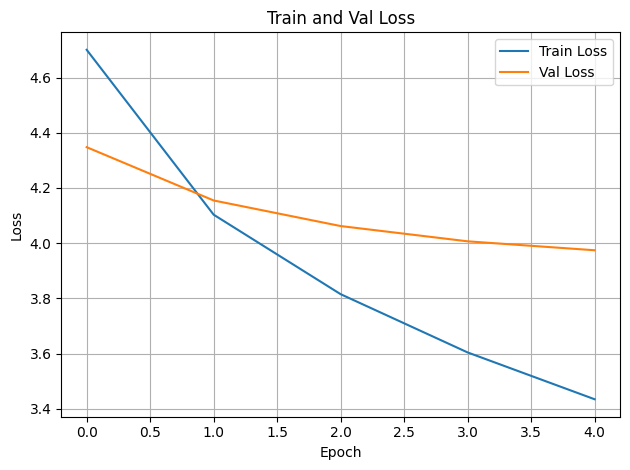

In [ ]:
plot_losses(losses_train, losses_val)

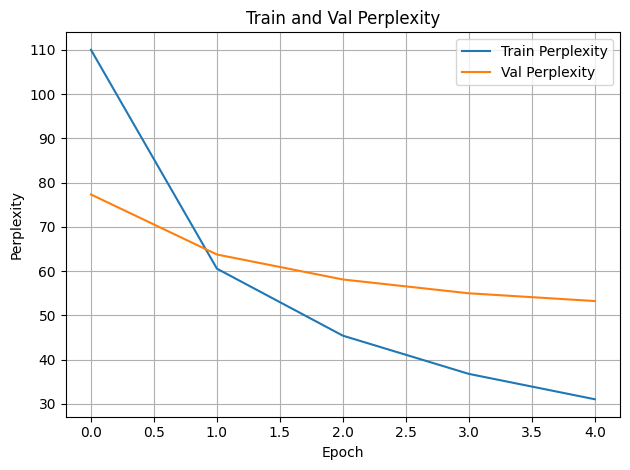

In [ ]:
plot_perplexities(perplexities_train, perplexities_val)

## Exemplo de uso
Como um modelo de linguagem pode gerar um texto? Pense como uma "janela deslizante", onde o contexto é sempre as palavras anteriores. Produza textos para avaliar o modelo de forma qualitativa.

In [ ]:
def generate_text(model, vocab, seed_text, max_length=20, device='cpu', context_size=5):
    """
    Gera texto a partir de um modelo de linguagem treinado.

    Args:
        model: modelo treinado (nn.Module)
        vocab: dicionário {token: id}
        seed_text: texto inicial (str)
        max_length: número máximo de palavras a gerar
        device: cpu ou cuda
        context_size: tamanho do contexto usado pelo modelo

    Returns:
        Texto gerado (str)
    """
    model.eval()
    model.to(device)
    id_to_token = {idx: tok for tok, idx in vocab.items()}

    # Tokeniza e converte seed_text para ids
    tokens = seed_text.strip().lower().split()
    context = [vocab.get(token, 0) for token in tokens[-context_size:]]

    # Preenche contexto se necessário
    if len(context) < context_size:
        context = [0] * (context_size - len(context)) + context

    generated = context.copy()

    for _ in range(max_length):
        x = torch.tensor([context], dtype=torch.long, device=device)
        with torch.no_grad():
            logits = model(x)
        next_id = torch.argmax(logits, dim=-1).item()
        generated.append(next_id)
        context = generated[-context_size:]

    # Converte ids para tokens, ignora <unk> se quiser
    result = [id_to_token.get(idx, '<unk>') for idx in generated if idx in id_to_token]
    return ' '.join(result)

In [ ]:
context = 5
max_length = 9
text = "Era uma dia belo de sol"
generate_text(model,vocab,text, max_length,device)

'uma dia belo de sol , e a noite , com a mesma coisa'

In [ ]:
text = "este é um texto gerado artificialmente"
generate_text(model,vocab,text, max_length,device)

'é um texto <unk> <unk> escrever um desses dois , que o nosso amigo'